In [1]:
import os
os.environ['OMP_NUM_THREADS'] = '1'
import stsynphot as stsyn
import matplotlib.pyplot as plt
import numpy as np
from astropy.io.fits import getheader
from zipfile import ZipFile
from astropy.io import fits
import numpy as np
import astropy.units as u
from matplotlib import pyplot as plt
from astropy.visualization import quantity_support
from astropy.io.fits import getheader
from specutils import Spectrum1D
from glob import glob
from termcolor import colored  
#from astropy.visualization import quantity_support
#quantity_support()  # for getting units on the axes below  
from specutils.manipulation import box_smooth
from specutils.manipulation import LinearInterpolatedResampler
import emcee
import corner
from multiprocessing import Pool

In [2]:
file_name = '/Users/kchen/FYPS/data.zip'

with ZipFile(file_name, 'r') as zip:
    zip.printdir()
    zip.extractall()

spectra = ZipFile(file_name, 'r')
number_of_spectra = len(spectra.namelist())

File Name                                             Modified             Size
rm177_010323.fits                              2023-05-18 13:16:32       783360
hv883_010323.fits                              2023-05-18 13:16:32       783360
hd268949_010323.fits                           2023-05-18 13:16:32       783360
hd268865_010323.fits                           2023-05-18 13:16:32       783360
hd268828_010323.fits                           2023-05-18 13:16:32       786240
hd268727_010323.fits                           2023-05-18 13:16:32       783360
j05344_122722.fits                             2023-05-18 13:16:18       783360
hd27005_122722.fits                            2023-05-18 13:16:18       783360
hd269982_122722.fits                           2023-05-18 13:16:18       783360
hd269953_122722.fits                           2023-05-18 13:16:18       783360
hd269902_122722.fits                           2023-05-18 13:16:18       783360
hd269879_122722.fits                    

In [3]:
#grab anything that contains '.fits'
files = glob('*.fits')
print(files)
# hdr = getheader(files[1])
# print(hdr)
print(files[1])

['hd269879_122722.fits', 'hd269857_122722.fits', 'hd27005_122722.fits', 'hd269723_122722.fits', 'hd269662_122622.fits', 'hd269070_122622.fits', 'sk_69_99_122622.fits', 'hd269697_122722.fits', 'hd269902_122722.fits', 'w60_d17_122622.fits', 'hd269331_122622.fits', 'hd269661_122622.fits', 'hd268727_010323.fits', 'hd269762_122722.fits', 'hd269953_122722.fits', 'hd33579_122622.fits', 'hv2450_122622.fits', 'hv883_010323.fits', 'hd269604_122622.fits', 'hd268819_122622.fits', 'j05344_122722.fits', 'cd_69_310_122622.fits', 'sp77_31_16_122622.fits', 'cpd-69-496_122722.fits', 'hd268687_122622.fits', 'sp77_48_6_122622.fits', 'hd268828_010323.fits', 'hd269651_122622.fits', 'hd269982_122722.fits', 'sk_69_148_122622.fits', 'hd268949_010323.fits', 'hd268946_122622.fits', 'hd269840_122722.fits', 'rm177_010323.fits', 'hd269110_122622.fits', 'hd269787_122722.fits', 'hd269807_122722.fits', 'out.fits', 'hd268971_122622.fits', 'hd268865_010323.fits']
hd269857_122722.fits


In [212]:
def graph(i, wavelength):
    """
    This takes an integer value i and 
    outputs the graph corresponding to that number in the list from the data.zip file. with wavelength stated
    """
    

    hdulist = fits.open(str(files[i]))
    hdr = getheader(files[i])
    spec1d = Spectrum1D.read("/Users/kchen/FYPS/"+ files[i])
    filename = '/Users/kchen/FYPS/' + files[i]
# The spectrum is in the first HDU of this file.
    with fits.open(filename) as f:  
        specdata = f[0].data
    text = colored('----------------\nThis graph is: ' + files[i] + ' and array ' + str(i), 'red', attrs=['bold'])  
    print(text)  
    print(specdata)
    
    print(spec1d)
    
    ax = plt.subplots()[1] 
    ax.plot(spec1d.spectral_axis, spec1d.flux)
    ax.set_xlim(3000,9000)
    ax.set_ylim(0,1.4e-13)
#    plt.show()

In [114]:
?stsyn.grid_to_spec


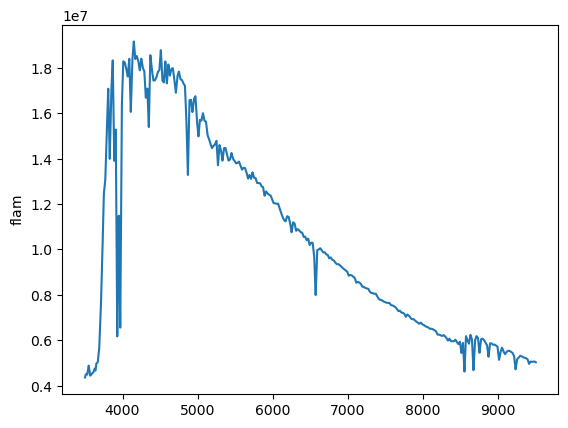

In [115]:
wavelength = np.linspace(3500, 9500, 20000) # wavelength grid of 20k points
model = stsyn.grid_to_spec('ck04models', 6300, -0.25, 0.5) #model from Castelli & Kurucz (2004)

model_flux = model(wavelength, flux_unit='flam') #flux units are silly...

plt.plot(wavelength, model_flux)

In [610]:
def fit(t_eff, log_g, rv, ebv, radius, wavelength, i):
    """
    Takes effective temperature, surface gravity, radial velocity, reddening, and radius (in solar radii)--emitted vs observed Flux fobs=fsurface(R/d)^2, multiply reddening by (r/d)^2. R in solar radii. d=158200 lightyear 
    and an array of wavelength points and 
    outputs corresponding model flux evaluated on the wavelength array
    """

    model = stsyn.grid_to_spec('ck04models', t_eff, -0.25, log_g) #model from Castelli & Kurucz (2004)
    model.z = rv/(299792458/1000) #speed of light converted from m/s to km/s
    
    reddening = stsyn.spectrum.ebmvx('lmcavg', ebv) #average of total/selective dimming
    
    
    reddenedmodel = reddening*model
    
    reddenedmodel_flux = reddenedmodel(wavelength, flux_unit='flam')
    
    reddenedmodel_flux*=(radius/(2.15134e12))**2

    
    
    
    hdulist = fits.open(str(files[i]))
    hdr = getheader(files[i])
    spec1d = Spectrum1D.read("/Users/kchen/FYPS/"+ files[i])
    filename = '/Users/kchen/FYPS/' + files[i]
# The spectrum is in the first HDU of this file.
    with fits.open(filename) as f:  
        specdata = f[0].data
    text = colored('----------------\nThis graph is: ' + files[i] + ' and array ' + str(i), 'red', attrs=['bold'])  
    print(text)  
    print(specdata)
    
    print(spec1d)
    
    ax = plt.subplots()[1] 
    ax.plot(spec1d.spectral_axis.value, spec1d.flux.value)
    ax.set_xlim(3000,9700)
    #ax.set_ylim(0,2e-13)
    plt.plot(wavelength, reddenedmodel_flux)
    plt.show
    diff=np.diff(spec1d.spectral_axis.value) #find resolution diff
    print(diff)

----------------
This graph is: hd269857_122722.fits and array 1
[0.000000e+00 0.000000e+00 0.000000e+00 ... 9.164395e-14 9.208172e-14
 9.241548e-14]
Spectrum1D (length=192788)
flux:             [ 0.0 erg / (A cm2 s), ..., 9.2415e-14 erg / (A cm2 s) ],  mean=1.829e-13 erg / (A cm2 s)
spectral axis:    [ 3323.7 Angstrom, ..., 9668.3 Angstrom ],  mean=6496.0 Angstrom
[0.03290965 0.03290965 0.03290965 ... 0.03290965 0.03290965 0.03290965]


----------------
This graph is: hd269857_122722.fits and array 1
[0.000000e+00 0.000000e+00 0.000000e+00 ... 9.164395e-14 9.208172e-14
 9.241548e-14]
Spectrum1D (length=192788)
flux:             [ 0.0 erg / (A cm2 s), ..., 9.2415e-14 erg / (A cm2 s) ],  mean=1.829e-13 erg / (A cm2 s)
spectral axis:    [ 3323.7 Angstrom, ..., 9668.3 Angstrom ],  mean=6496.0 Angstrom
[0.03290965 0.03290965 0.03290965 ... 0.03290965 0.03290965 0.03290965]


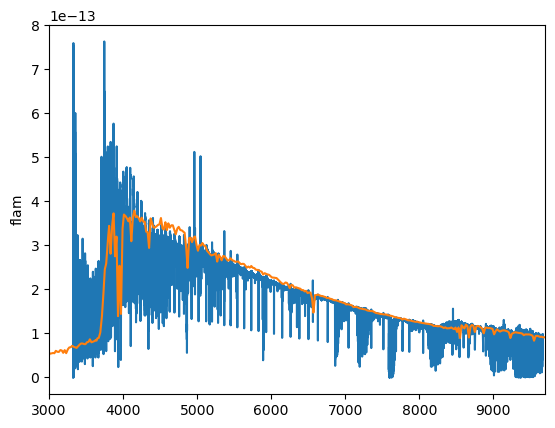

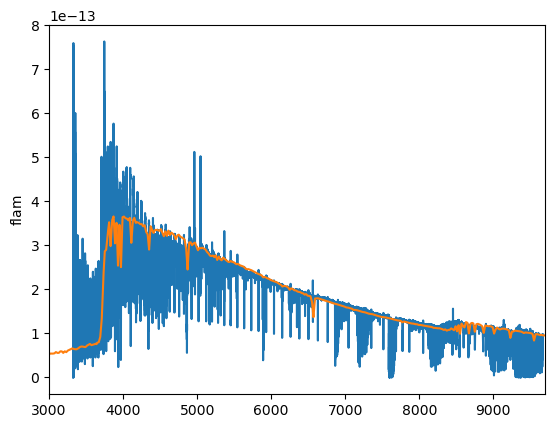

In [446]:
#1, actual teff: 7400
wavelength = np.linspace(3000, 9700, 20000) # wavelength grid 
#fit(6350, 1.2, 0, .01, 300, wavelength, 1)
fit(6500, .5, 0, .05, 300, wavelength, 1) #guess
fit(7400, .5, 0, .225, 300, wavelength, 1) #using known value

----------------
This graph is: w60_d17_122622.fits and array 9
[9.1347654e-13 0.0000000e+00 0.0000000e+00 ... 7.6088075e-14 7.6335470e-14
 7.6519317e-14]
Spectrum1D (length=192427)
flux:             [ 9.1348e-13 erg / (A cm2 s), ..., 7.6519e-14 erg / (A cm2 s) ],  mean=7.3338e-14 erg / (A cm2 s)
spectral axis:    [ 3322.2 Angstrom, ..., 9666.8 Angstrom ],  mean=6494.5 Angstrom


----------------
This graph is: w60_d17_122622.fits and array 9
[9.1347654e-13 0.0000000e+00 0.0000000e+00 ... 7.6088075e-14 7.6335470e-14
 7.6519317e-14]
Spectrum1D (length=192427)
flux:             [ 9.1348e-13 erg / (A cm2 s), ..., 7.6519e-14 erg / (A cm2 s) ],  mean=7.3338e-14 erg / (A cm2 s)
spectral axis:    [ 3322.2 Angstrom, ..., 9666.8 Angstrom ],  mean=6494.5 Angstrom


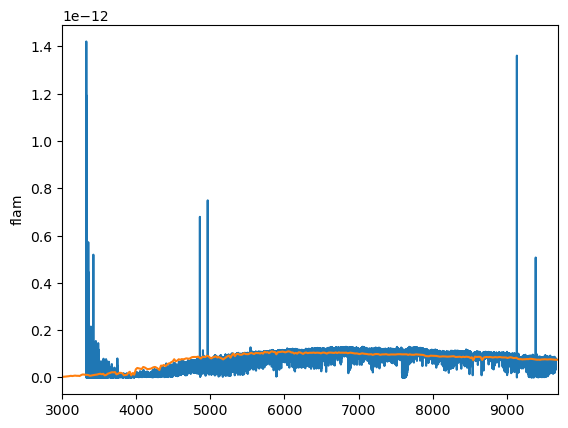

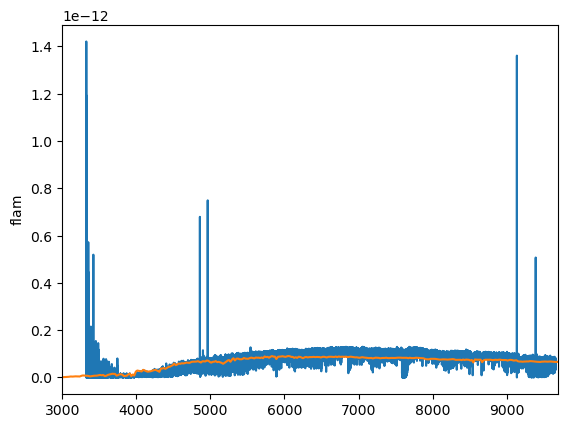

In [429]:
#9, actual teff: 4440
wavelength = np.linspace(3000, 9700, 20000) # wavelength grid 

#fit(6000, 2, 0, .6, 490, wavelength, 9)
fit(4590, 2, 0, .1, 500, wavelength, 9)
fit(4440, 2, 0, .1, 500, wavelength, 9) #actual

----------------
This graph is: hd269723_122722.fits and array 3
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.4722759e-13 2.4533766e-13
 2.4406060e-13]
Spectrum1D (length=192769)
flux:             [ 0.0 erg / (A cm2 s), ..., 2.4406e-13 erg / (A cm2 s) ],  mean=2.7851e-13 erg / (A cm2 s)
spectral axis:    [ 3322.9 Angstrom, ..., 9666.1 Angstrom ],  mean=6494.5 Angstrom
[0.03290576 0.03290576 0.03290576 ... 0.03290576 0.03290576 0.03290576]


----------------
This graph is: hd269723_122722.fits and array 3
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.4722759e-13 2.4533766e-13
 2.4406060e-13]
Spectrum1D (length=192769)
flux:             [ 0.0 erg / (A cm2 s), ..., 2.4406e-13 erg / (A cm2 s) ],  mean=2.7851e-13 erg / (A cm2 s)
spectral axis:    [ 3322.9 Angstrom, ..., 9666.1 Angstrom ],  mean=6494.5 Angstrom
[0.03290576 0.03290576 0.03290576 ... 0.03290576 0.03290576 0.03290576]


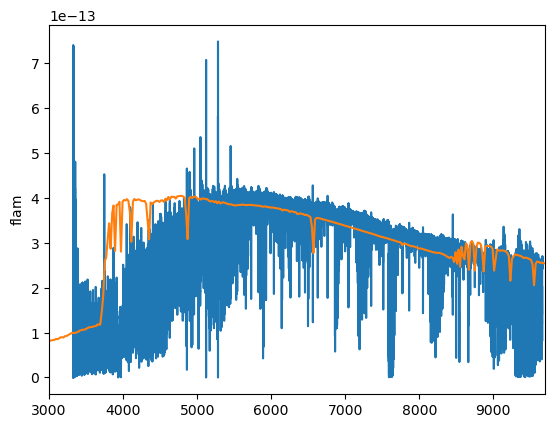

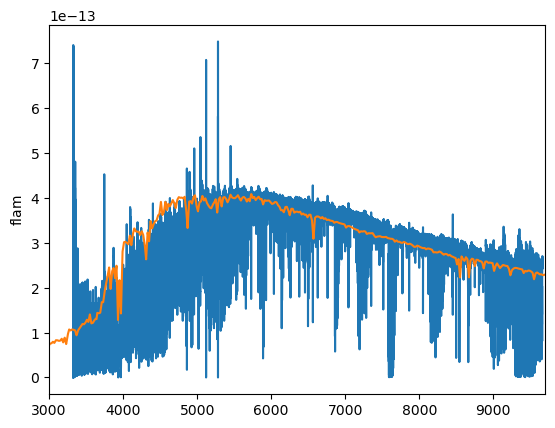

In [611]:
#3, actual teff:5930
fit(9950, 2.5, 0, .69, 500, wavelength, 3)
fit(5930, 2.5, 0, .25, 640, wavelength, 3) #actual

In [4]:
def lowres(t_eff, log_g, rv, ebv, radius, wavelength, i):
    """
    Takes effective temperature, surface gravity, radial velocity, reddening, and radius (in solar radii)--emitted vs observed Flux fobs=fsurface(R/d)^2, multiply reddening by (r/d)^2. R in solar radii. d=158200 lightyear 
    and an array of wavelength points and 
    outputs corresponding model flux evaluated on the wavelength array
    """

    model = stsyn.grid_to_spec('ck04models', t_eff, -0.25, log_g) #model from Castelli & Kurucz (2004)
    model.z = rv/(299792458/1000) #speed of light converted from m/s to km/s
    
    reddening = stsyn.spectrum.ebmvx('lmcavg', ebv) #average of total/selective dimming
    
    
    reddenedmodel = reddening*model
    
    reddenedmodel_flux = reddenedmodel(wavelength, flux_unit='flam')
    
    reddenedmodel_flux*=(radius/(2.15134e12))**2

    
    
    
    hdulist = fits.open(str(files[i]))
    hdr = getheader(files[i])
    spec1d = Spectrum1D.read("/Users/kchen/FYPS/"+ files[i])
    filename = '/Users/kchen/FYPS/' + files[i]
# The spectrum is in the first HDU of this file.
    with fits.open(filename) as f:  
        specdata = f[0].data
    text = colored('----------------\nThis graph is: ' + files[i] + ' and array ' + str(i), 'red', attrs=['bold'])  
    print(text)  
    print(specdata)
    
    print(spec1d)
    
    #lowres
    spec_smooth = box_smooth(spec1d, width=1500)
    wavelength_grid = np.arange(spec1d.spectral_axis.value.min(), spec1d.spectral_axis.value.max(), 20) * u.AA
    linear = LinearInterpolatedResampler()
    spec_interp = linear(spec_smooth, wavelength_grid)
    
    
    ax = plt.subplots()[1] 
    ax.plot(spec_interp.spectral_axis.value, spec_interp.flux.value)
    ax.set_xlim(3000,9700)
    #ax.set_ylim(0,2e-13)
    ax.set_ylabel('Flux (erg/cm^2/s/Å)')
    ax.set_xlabel('Wavelength (Å)')
    plt.plot(wavelength, reddenedmodel_flux)
    plt.show
    diff=np.diff(spec1d.spectral_axis.value) #find resolution diff
    print(diff)
    
    


    

# First thing to do: experiment with width parameter until the data start to look the same resolution as the model. Start with width=1 and width=1000000

# Next:

# 

# wavelength_grid = [you'll write code to have a wavelength grid between 3500 and 9500 with step side of 20 Angstroms] 
# linear = LinearInterpolatedResampler()
# spec_interp = linear(spec_smooth, wavelength_grid)


----------------
This graph is: hd269857_122722.fits and array 1
[0.000000e+00 0.000000e+00 0.000000e+00 ... 9.164395e-14 9.208172e-14
 9.241548e-14]
Spectrum1D (length=192788)
flux:             [ 0.0 erg / (A cm2 s), ..., 9.2415e-14 erg / (A cm2 s) ],  mean=1.829e-13 erg / (A cm2 s)
spectral axis:    [ 3323.7 Angstrom, ..., 9668.3 Angstrom ],  mean=6496.0 Angstrom
[0.03290965 0.03290965 0.03290965 ... 0.03290965 0.03290965 0.03290965]


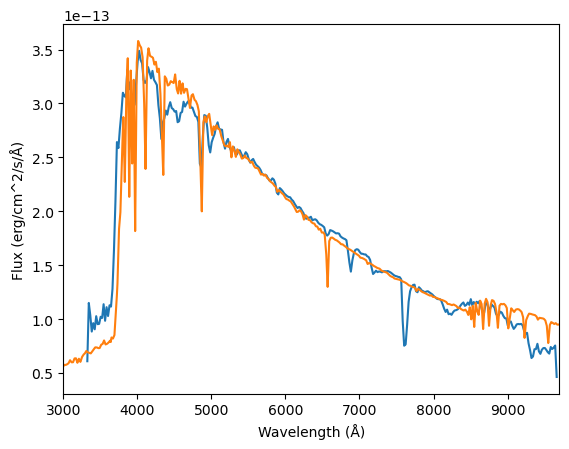

In [545]:

lowres(7400, 2, 0, .243, 304, wavelength, 1)

In [632]:
def all(t_eff, log_g, rv, ebv, radius, wavelength, t_eff1, log_g1, rv1, ebv1, radius1, i):
    """
    Takes effective temperature, surface gravity, radial velocity, reddening, and radius (in solar radii)--emitted vs observed Flux fobs=fsurface(R/d)^2, multiply reddening by (r/d)^2. R in solar radii. d=158200 lightyear 
    and an array of wavelength points and 
    outputs corresponding model flux evaluated on the wavelength array
    """

    model = stsyn.grid_to_spec('ck04models', t_eff, -0.25, log_g) #model from Castelli & Kurucz (2004)
    model.z = rv/(299792458/1000) #speed of light converted from m/s to km/s
    
    reddening = stsyn.spectrum.ebmvx('lmcavg', ebv) #average of total/selective dimming
    
    
    reddenedmodel = reddening*model
    
    reddenedmodel_flux = reddenedmodel(wavelength, flux_unit='flam')
    
    reddenedmodel_flux*=(radius/(2.15134e12))**2

    #wrong teff
    model1 = stsyn.grid_to_spec('ck04models', t_eff1, -0.25, log_g1) #model from Castelli & Kurucz (2004)
    model.z1 = rv1/(299792458/1000) #speed of light converted from m/s to km/s
    
    reddening1 = stsyn.spectrum.ebmvx('lmcavg', ebv1) #average of total/selective dimming
    
    
    reddenedmodel1 = reddening1*model1
    
    reddenedmodel_flux1 = reddenedmodel1(wavelength, flux_unit='flam')
    
    reddenedmodel_flux1*=(radius1/(2.15134e12))**2
    
    
    
    hdulist = fits.open(str(files[i]))
    hdr = getheader(files[i])
    spec1d = Spectrum1D.read("/Users/kchen/FYPS/"+ files[i])
    filename = '/Users/kchen/FYPS/' + files[i]
# The spectrum is in the first HDU of this file.
    with fits.open(filename) as f:  
        specdata = f[0].data
    text = colored('----------------\nThis graph is: ' + files[i] + ' and array ' + str(i), 'red', attrs=['bold'])  
    print(text)  
    print(specdata)
    
    print(spec1d)
    
    #lowres
    spec_smooth = box_smooth(spec1d, width=1500)
    wavelength_grid = np.arange(spec1d.spectral_axis.value.min(), spec1d.spectral_axis.value.max(), 20) * u.AA
    linear = LinearInterpolatedResampler()
    spec_interp = linear(spec_smooth, wavelength_grid)
    
    
    ax = plt.subplots(dpi=300)[1] 
    #ax.plot(spec1d.spectral_axis.value, spec1d.flux.value, alpha=.3, label= 'original data')
    ax.plot(spec_interp.spectral_axis.value, spec_interp.flux.value, label='smoothed data', lw=2)
    ax.set_xlim(3000,9700)
    #ax.set_ylim(0,2e-13)
    ax.set_ylabel('Flux (erg/cm^2/s/Å)')
    ax.set_xlabel('Wavelength (Å)')
    plt.plot(wavelength, reddenedmodel_flux, label='SIMBAD temperature')
    plt.plot(wavelength, reddenedmodel_flux1, label='by-eye model', alpha=.8)
    
    
    plt.show
    diff=np.diff(spec1d.spectral_axis.value) #find resolution diff
    print(diff)
    ax.legend(loc='upper right')


In [5]:
def logprior(theta):
    t_eff, log_g, rv, ebv, radius = theta #theta is an array containing parameter values, which we unpack into individual variables
    if (4000 <= t_eff <= 12500) & (-.5<=log_g<=3) & (-50<=rv<=50) & (0<=ebv<=2.5) & (1<=radius<=1000): 
        try: #this step makes sure the parameter combination loads the correct model
            model = stsyn.grid_to_spec('ck04models', t_eff, -0.25, log_g)
            return model
        except: #if this breaks stsynphot...
            return -np.inf #if there's no model here, this is a bad parameter set! so return negative infinity!!
    else: #if we're also outside of the parameter bounds...
        return -np.inf #it's bad! So we return negative infinity!!


----------------
This graph is: hd269723_122722.fits and array 3
[0.0000000e+00 0.0000000e+00 0.0000000e+00 ... 2.4722759e-13 2.4533766e-13
 2.4406060e-13]
Spectrum1D (length=192769)
flux:             [ 0.0 erg / (A cm2 s), ..., 2.4406e-13 erg / (A cm2 s) ],  mean=2.7851e-13 erg / (A cm2 s)
spectral axis:    [ 3322.9 Angstrom, ..., 9666.1 Angstrom ],  mean=6494.5 Angstrom
[0.03290576 0.03290576 0.03290576 ... 0.03290576 0.03290576 0.03290576]


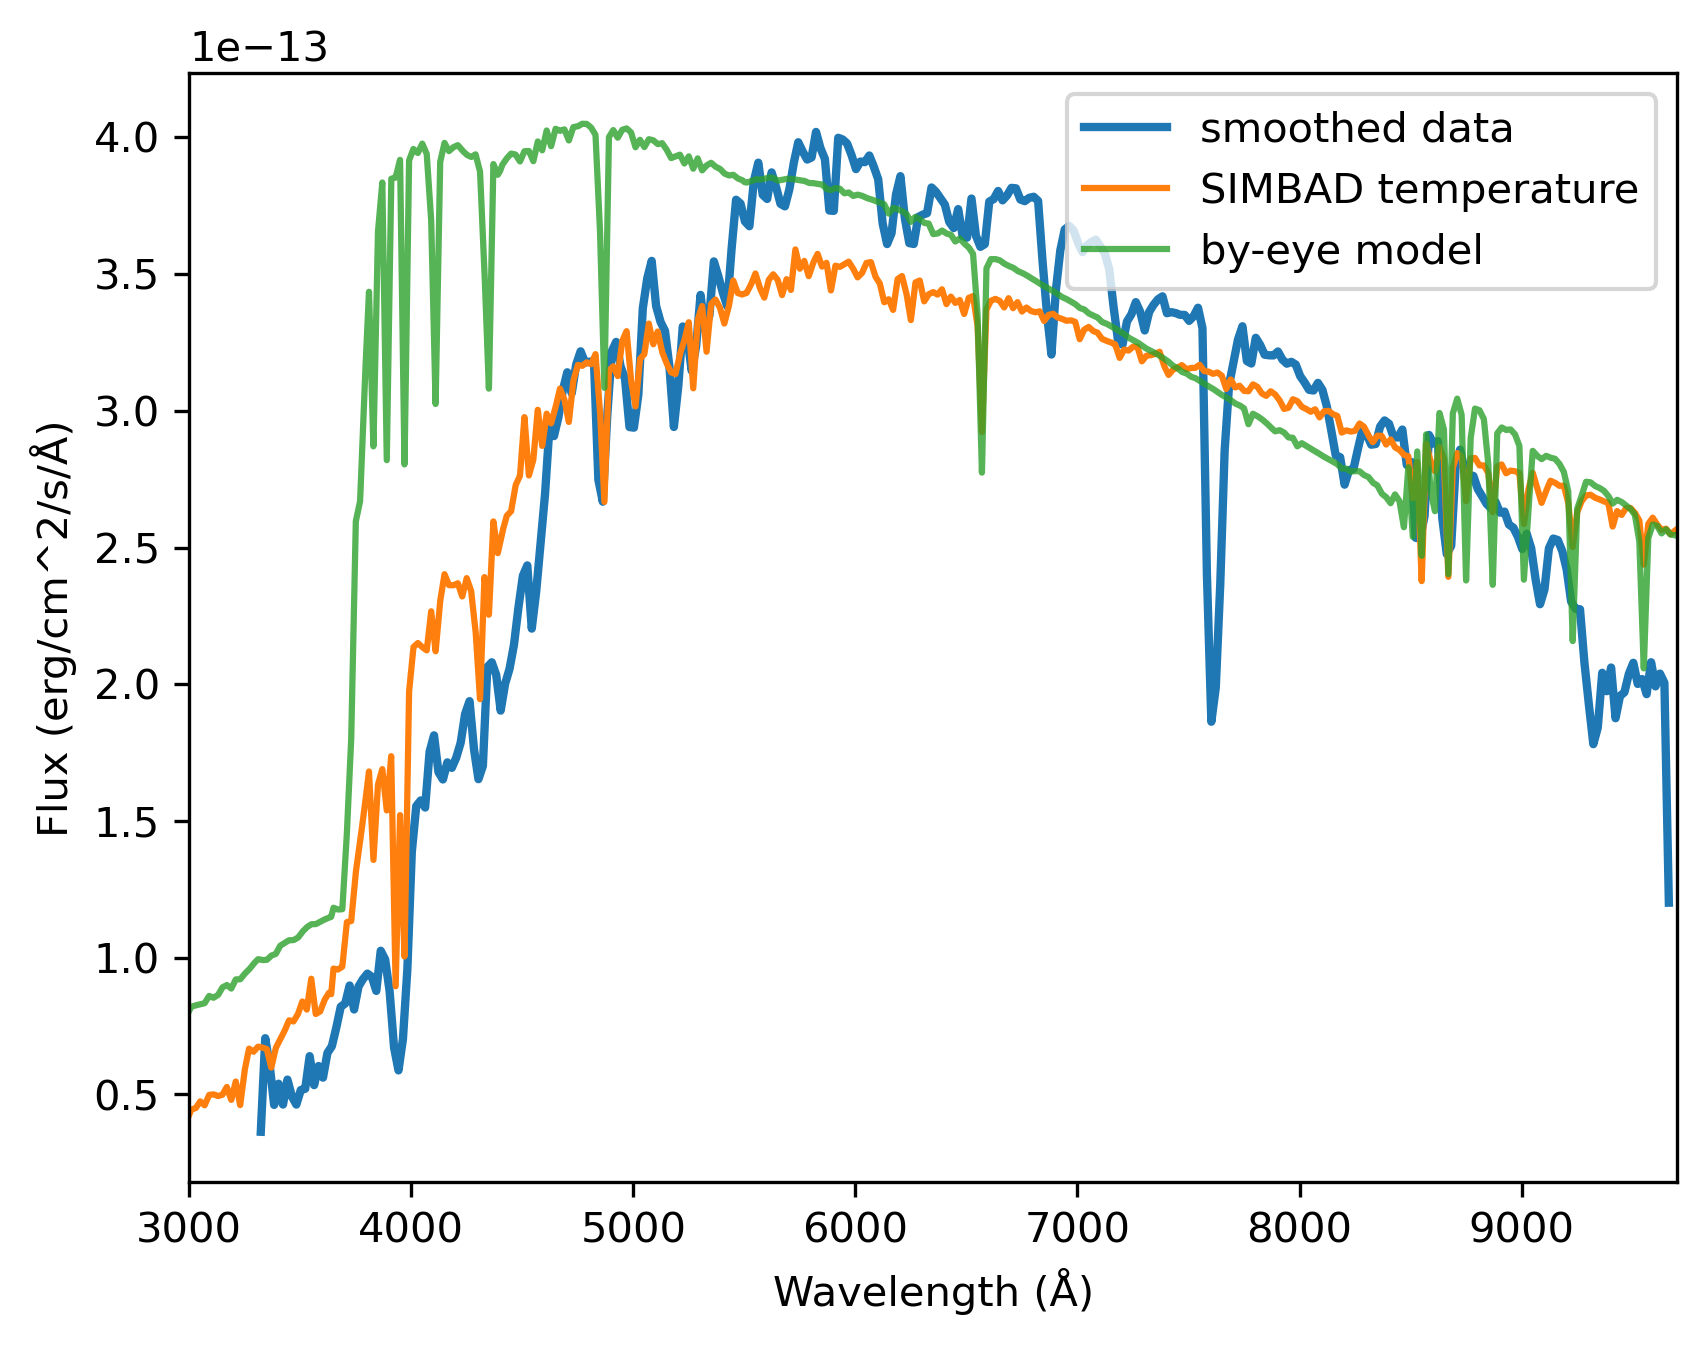

In [633]:
#(9950, 2.5, 0, .69, 500, wavelength, 3)
all(5930, 2.5, 0, .4, 750, wavelength, 9950, 2.5, 0, .69, 500, 3)

In [6]:
#test logprior
theta=[10000, -0.25, 0, 0, 200]

logprior(theta)==-np.inf

True

In [7]:
def logprob(theta, wavelength, flux):
    lprior=logprior(theta)
    if lprior==-np.inf:
        return -np.inf
    t_eff, log_g, rv, ebv, radius = theta
    model=lprior

    model.z = rv/(299792458/1000) #speed of light converted from m/s to km/s

    reddening = stsyn.spectrum.ebmvx('lmcavg', ebv) #average of total/selective dimming

    
    reddenedmodel = reddening*model

    reddenedmodel_flux = reddenedmodel(wavelength, flux_unit='flam')
    
    reddenedmodel_flux*=(radius/(2.15134e12))**2


    
    
    error=flux/200

    
    chi=((flux-reddenedmodel_flux.value)**2)/(error**2)
    return chi.sum() * -0.5


In [8]:
logprior(theta)

-inf

In [9]:
#MC
def choosefile(i):
    hdulist = fits.open(str(files[i]))
    hdr = getheader(files[i])
    spec1d = Spectrum1D.read(files[i])
    filename = files[i]
# The spectrum is in the first HDU of this file.
    with fits.open(filename) as f:  
        specdata = f[0].data
    #text = colored('----------------\nThis graph is: ' + files[i] + ' and array ' + str(i), 'red', attrs=['bold'])  
#     print(text)  
#     print(specdata)
    
#     print(spec1d)
    
    #lowres
    spec_smooth = box_smooth(spec1d, width=1500)
    wavelength_grid = np.arange(spec1d.spectral_axis.value.min(), spec1d.spectral_axis.value.max(), 20) * u.AA
    linear = LinearInterpolatedResampler()
    spec_interp = linear(spec_smooth, wavelength_grid)
    
    wavelength = spec_interp.spectral_axis.value
    flux = spec_interp.flux.value
    fitsname=files[i]
    
    
    return wavelength, flux, fitsname
#     print(wavelength)
#     print(flux)
    


In [10]:
wavelength, flux, fitsname = choosefile(1)
wavelength.shape

(318,)

In [11]:
theta=[6549.725, 1.619, 20, 0, 264]
pos.shape
logprob(pos[0],wavelength,flux)


NameError: name 'pos' is not defined

In [13]:

theta=[6549.725, 1.619, 20, 5e-4, 264]
pos = theta + 1e-4 * np.random.randn(16, 5) #this initializes our walkers in a small little random ball around your starting guess
 
nwalkers, ndim = pos.shape
 
filename = fitsname + '_emcee.h5' 
backend = emcee.backends.HDFBackend(filename)

#with Pool(4) as pool:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, logprob, args=(wavelength, flux)#, backend=backend#, pool=pool
)
sampler.run_mcmc(pos, 5000, progress=True);


  3%|█                                     | 139/5000 [09:34<4:19:30,  3.20s/it]Traceback (most recent call last):
  File "/Users/kchen/anaconda3/lib/python3.10/site-packages/emcee/ensemble.py", line 624, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/c4/wt3q5wqs15q2_09lr7xm4tnc0000gs/T/ipykernel_63064/2756862869.py", line 13, in logprob
    reddenedmodel = reddening*model
  File "/Users/kchen/anaconda3/lib/python3.10/site-packages/synphot/spectrum.py", line 1416, in __mul__
    newcls = other.__mul__(self)
  File "/Users/kchen/anaconda3/lib/python3.10/site-packages/synphot/spectrum.py", line 1234, in __mul__
    newcls = self.__class__(self.model * other.model)
  File "/Users/kchen/anaconda3/lib/python3.10/site-packages/synphot/spectrum.py", line 1137, in __init__
    super(SourceSpectrum, self).__init__(modelclass, **kwargs)
  File "/Users/kchen/anaconda3/lib/python3.10/site-packages/synphot/spectrum.py", line 192, in __init__
    m_meta = get_metada

emcee: Exception while calling your likelihood function:
  params: [6.54829063e+03 1.61196710e+00 2.11056022e+01 7.34811137e-05
 2.64333333e+02]
  args: (array([3323.73095703, 3343.73095703, 3363.73095703, 3383.73095703,
       3403.73095703, 3423.73095703, 3443.73095703, 3463.73095703,
       3483.73095703, 3503.73095703, 3523.73095703, 3543.73095703,
       3563.73095703, 3583.73095703, 3603.73095703, 3623.73095703,
       3643.73095703, 3663.73095703, 3683.73095703, 3703.73095703,
       3723.73095703, 3743.73095703, 3763.73095703, 3783.73095703,
       3803.73095703, 3823.73095703, 3843.73095703, 3863.73095703,
       3883.73095703, 3903.73095703, 3923.73095703, 3943.73095703,
       3963.73095703, 3983.73095703, 4003.73095703, 4023.73095703,
       4043.73095703, 4063.73095703, 4083.73095703, 4103.73095703,
       4123.73095703, 4143.73095703, 4163.73095703, 4183.73095703,
       4203.73095703, 4223.73095703, 4243.73095703, 4263.73095703,
       4283.73095703, 4303.73095703, 4323.



KeyboardInterrupt



In [701]:
reader = emcee.backends.HDFBackend(filename)
samples = reader.get_chain(flat=True)
samples.shape

(84512, 5)

Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours
Too few points to create valid contours


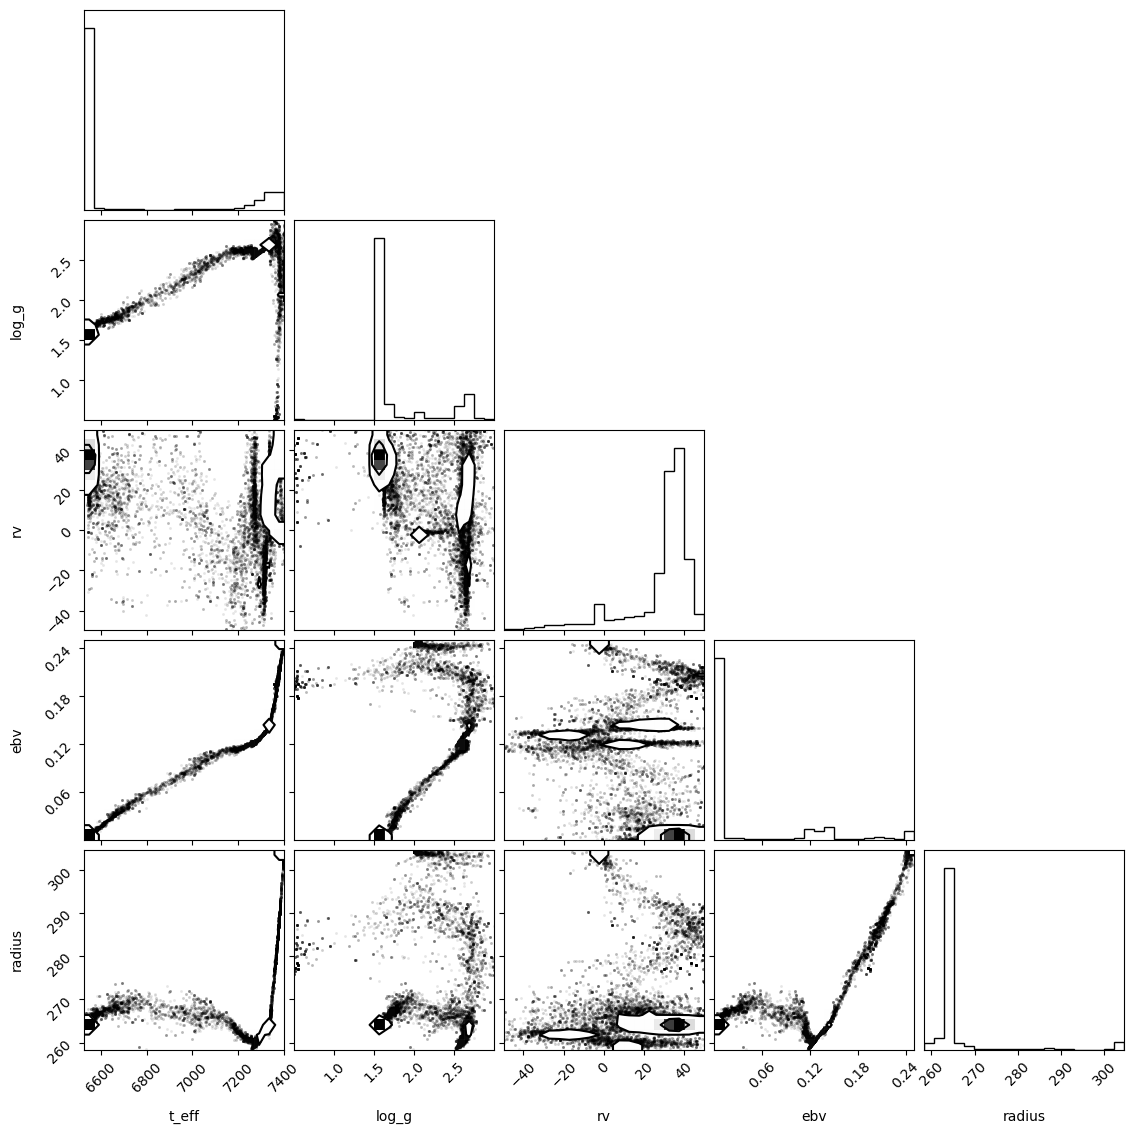

In [706]:
labels = ['t_eff', 'log_g', 'rv', 'ebv', 'radius']
fig = corner.corner(samples, labels=labels)

In [707]:
for i in range(5):
    mcmc = np.percentile(samples[:,i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    print(txt)

\mathrm{t_eff} = 6549.725_{-1.557}^{756.811}
\mathrm{log_g} = 1.619_{-0.005}^{0.913}
\mathrm{rv} = 34.124_{-17.424}^{5.484}
\mathrm{ebv} = 0.000_{-0.000}^{0.132}
\mathrm{radius} = 264.258_{-0.178}^{0.220}


In [ ]:
# We'll want to loop over every single spectrum and run the sampling. 
def mc(theta, i)
    for i in range(39):
        wavelength, flux, fitsname = choosefile(i)
        pos = theta + 1e-4 * np.random.randn(32, 5) #this initializes our walkers in a small little random ball around your starting guess
 
        nwalkers, ndim = pos.shape
 
        filename = "/Users/kchen/FYPS/" + fitsname + '_emcee.h5' 
        backend = emcee.backends.HDFBackend(filename)
 
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, logprob, args=(wavelength, flux), backend=backend
        )
        sampler.run_mcmc(pos, 5000, progress=True);


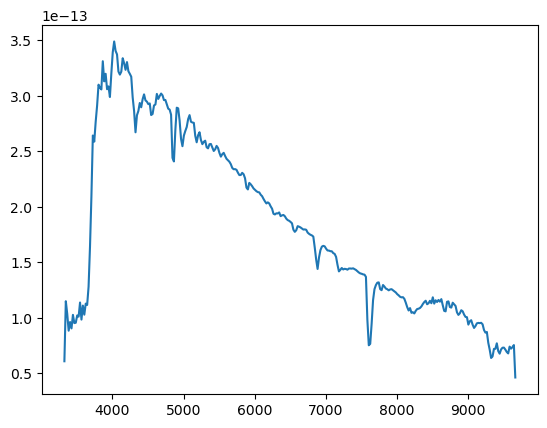

In [14]:
plt.plot(wavelength, flux)